# YOLO-V3 PPE Object Detection

#### Run script to prevent Colab random disconnects

In [1]:
# Prevent Colab Random Disconnects
import IPython
from google.colab import output
display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }
setInterval(ClickConnect,60000)
'''))
print("Done.")

<IPython.core.display.Javascript object>

Done.


#### Use YOLOV3 repo which contains scripts to train/test the model

In [2]:
!git clone https://github.com/ashxjain/YoloV3.git

Cloning into 'YoloV3'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 159 (delta 0), reused 1 (delta 0), pack-reused 156
Receiving objects: 100% (159/159), 12.75 MiB | 43.67 MiB/s, done.
Resolving deltas: 100% (7/7), done.


#### Mount GDrive path for fetching required files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [5]:
!ls -altrh drive/My\ Drive/EVA/Datasets/YoloV3-PPE/YoloV3_Dataset.zip

-rw------- 1 root root 265M Oct 22 16:16 'drive/My Drive/EVA/Datasets/YoloV3-PPE/YoloV3_Dataset.zip'


### Custom dataset - Setup appropriate files for training

In [ ]:
!unzip drive/My\ Drive/EVA/Datasets/YoloV3-PPE/YoloV3_Dataset.zip

In [7]:
%%shell
srcFolder="YoloV3_Dataset"
targetDataFolder="YoloV3/data/ppedata"
mkdir -p $targetDataFolder
# create ppe.data file
cat > $targetDataFolder/ppe.data <<EOF
classes=4
train=data/ppedata/ppetrain.txt
valid=data/ppedata/ppetest.txt 
names=data/ppedata/ppe.names
EOF

# copy required files from dataset
cp $srcFolder/classes.txt $targetDataFolder/ppe.names
mkdir -p $targetDataFolder/images && cp $srcFolder/Images/* $targetDataFolder/images/
mkdir -p $targetDataFolder/labels && cp $srcFolder/Labels/* $targetDataFolder/labels/
# Make sure any decimals around 1 i.e 1.xxxxx should be rounded off to 1.0
sed -i 's/1\.[0-9]*/1.0/g'  $targetDataFolder/labels/*

echo "> ppe.data"
cat $targetDataFolder/ppe.data

echo ""; echo "> ppe.names"
cat $targetDataFolder/ppe.names; echo""

> ppe.data
classes=4
train=data/ppedata/ppetrain.txt
valid=data/ppedata/ppetest.txt 
names=data/ppedata/ppe.names

> ppe.names
hardhat
vest
mask
boots


#### Split train/test images (9:1) based of Labels

In [8]:
import re
import os
import imagesize

srcFolder="YoloV3_Dataset"
targetDataFolder="YoloV3/data/ppedata"
trainFile = open(f'{targetDataFolder}/ppetrain.txt', 'w')
testFile = open(f'{targetDataFolder}/ppetest.txt', 'w')
trainShapesFile = open(f'{targetDataFolder}/ppetrain.shapes', 'w')
testShapesFile = open(f'{targetDataFolder}/ppetest.shapes', 'w')
labelFiles = os.listdir(srcFolder + "/Labels")
imgFiles = os.listdir(srcFolder + "/Images")
count = 0
testCnt = len(labelFiles)/10
trainCnt = len(labelFiles) - testCnt
for file in labelFiles:
  imgParts = file.split(".txt")
  r = re.compile(re.escape(imgParts[0])+".*")
  found = False
  for imgFile in imgFiles:
    if r.match(imgFile):
      shape = imagesize.get(f'{srcFolder}/Images/{imgFile}')
      if count < trainCnt:
        trainFile.write(f'./data/ppedata/images/{imgFile}\n')
        if shape: trainShapesFile.write(f'{shape[0]} {shape[1]}\n')
      else:
        testFile.write(f'./data/ppedata/images/{imgFile}\n')
        if shape: testShapesFile.write(f'{shape[0]} {shape[1]}\n')
      count+=1
      found = True
      break
trainFile.close()
testFile.close()
trainShapesFile.close()
testShapesFile.close()

!echo "Total train images: $(cat YoloV3/data/ppedata/ppetrain.txt | wc -l)"
!echo "Total train image shapes: $(cat YoloV3/data/ppedata/ppetrain.shapes | wc -l)"
!echo "Top 5 lines of train file: $(head -n 5 YoloV3/data/ppedata/ppetrain.txt)"
!echo "";
!echo "Total test images: $(cat YoloV3/data/ppedata/ppetest.txt | wc -l)"
!echo "Total test image shapes: $(cat YoloV3/data/ppedata/ppetest.shapes | wc -l)"
!echo "Top 5 lines of test file: $(head -n 5 YoloV3/data/ppedata/ppetest.txt)"

Total train images: 3174
Total train image shapes: 3174
Top 5 lines of train file: ./data/ppedata/images/R2.jpg
./data/ppedata/images/Himage_064.jpg
./data/ppedata/images/K200.jpg
./data/ppedata/images/M_004.jpg
./data/ppedata/images/9k_ (6).jpg

Total test images: 347
Total test image shapes: 347
Top 5 lines of test file: ./data/ppedata/images/images346.jpg
./data/ppedata/images/LImage_078.jpg
./data/ppedata/images/img17.jpg
./data/ppedata/images/Kv.jpg
./data/ppedata/images/portrait-of-worker-picture-id999554134.jpg


#### Change architecture based on Dataset
* For COCO's 80 classes, YOLOv3's output vector has 255 dimensions ( (4+1+80)*3)* Now we have 4 class, so we would need to change it's architecture.

In [9]:
%%shell
# Copy the contents of 'yolov3-spp.cfg' file to a new file called 'yolov3-ppe.cfg' file in the data/cfg folder.
cp YoloV3/cfg/yolov3-spp.cfg YoloV3/cfg/yolov3-ppe.cfg

# Search for 'filters=255' (you should get entries entries). Change 255 to *27* = (4+1+4)*3
sed -i 's/filters=255/filters=27/g' YoloV3/cfg/yolov3-ppe.cfg

# Search for 'classes=80' and change all three entries to 'classes=4'
sed -i 's/classes=80/classes=4/g' YoloV3/cfg/yolov3-ppe.cfg

sed -i 's/burn_in.*/burn_in=100/g' YoloV3/cfg/yolov3-ppe.cfg
sed -i 's/max_batches.*/max_batches=5000/g' YoloV3/cfg/yolov3-ppe.cfg
sed -i 's/steps=.*/steps=4000,4500/g' YoloV3/cfg/yolov3-ppe.cfg

# Verify if changes took place successfully
grep "filters=27" YoloV3/cfg/yolov3-ppe.cfg
grep "classes" YoloV3/cfg/yolov3-ppe.cfg
grep "burn_in" YoloV3/cfg/yolov3-ppe.cfg
grep "max_batches" YoloV3/cfg/yolov3-ppe.cfg
grep "steps=" YoloV3/cfg/yolov3-ppe.cfg

filters=27
filters=27
filters=27
classes=4
classes=4
classes=4
burn_in=100
max_batches=5000
steps=4000,4500


#### Download model weights

In [10]:
# Create a folder called weights in the root (YoloV3) folder
!mkdir -p YoloV3/weights
!cp drive/My\ Drive/weights/*.pt YoloV3/weights/

In [11]:
!cd YoloV3/; ls weights; ls data/ppedata

best.pt  yolov3_best_300.pt  yolov3-spp-ultralytics.pt
last.pt  yolov3_last_300.pt
images	ppe.data   ppetest.shapes  ppetrain.shapes
labels	ppe.names  ppetest.txt	   ppetrain.txt


#### Perform training

In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 40 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=40, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-25 18:33:01.702143: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 1934.32it/s]
Caching images (1.8GB): 100% 3174/3174 [00:20<00:00, 154.55it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 2941.82it/s]
C

In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 60 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=60, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-25 19:47:20.619594: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:00<00:00, 4308.05it/s]
Caching images (1.8GB): 100% 3174/3174 [00:20<00:00, 153.00it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1761.60it/s]
C

In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 80 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=80, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-25 22:16:01.028801: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:00<00:00, 4173.84it/s]
Caching images (1.8GB): 100% 3174/3174 [00:20<00:00, 152.69it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1820.95it/s]
C

In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 100 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=100, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 00:45:04.969321: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:00<00:00, 4038.33it/s]
Caching images (1.8GB): 100% 3174/3174 [00:23<00:00, 136.49it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1663.11it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 120 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=120, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 04:30:01.031334: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2466.94it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 150.30it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1765.89it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 140 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=140, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 07:03:07.887850: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2075.17it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 146.45it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 3393.95it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 160 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=160, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 09:33:27.862602: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2091.83it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 149.27it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1592.80it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 170 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=170, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 14:31:04.696712: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2467.46it/s]
Caching images (1.8GB): 100% 3174/3174 [00:20<00:00, 154.87it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1649.78it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 180 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=180, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 15:56:27.515043: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 1995.37it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 149.45it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 3729.50it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 200 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=200, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 18:53:31.569294: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2995 found, 131 missing, 48 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2464.83it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 147.37it/s]
Caching labels (326 found, 17 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1804.59it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 220 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=220, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-26 21:23:03.680613: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2995 found, 131 missing, 48 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2077.54it/s]
Caching images (1.8GB): 100% 3174/3174 [00:24<00:00, 129.45it/s]
Caching labels (326 found, 17 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 2792.66it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 240 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=240, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-27 03:02:12.162592: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2995 found, 131 missing, 48 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2445.17it/s]
Caching images (1.8GB): 100% 3174/3174 [00:23<00:00, 136.90it/s]
Caching labels (326 found, 17 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1656.93it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 260 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=260, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-27 05:27:58.350103: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2995 found, 131 missing, 48 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2039.85it/s]
Caching images (1.8GB): 100% 3174/3174 [00:22<00:00, 140.91it/s]
Caching labels (326 found, 17 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 3953.76it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 280 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=280, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-27 07:53:56.139027: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2995 found, 131 missing, 48 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 2079.14it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 146.88it/s]
Caching labels (326 found, 17 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 1866.69it/s]


In [ ]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 300 --resume
!cp YoloV3/weights/*.pt drive/My\ Drive/weights/

Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=300, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-27 10:19:50.820157: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2995 found, 131 missing, 48 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:01<00:00, 1831.21it/s]
Caching images (1.8GB): 100% 3174/3174 [00:22<00:00, 140.54it/s]
Caching labels (326 found, 17 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:00, 2789.02it/s]


#### Download sample video containing our classes

In [37]:
!rm YoloV3/data/source_imgs/*
!rm YoloV3/out_imgs/*

In [38]:
%%shell
wget https://github.com/ashxjain/eva/raw/master/P5_S13/sample_videos/video1.mp4
mkdir -p YoloV3/data/source_imgs
mv video1.mp4 YoloV3/data/source_imgs/
cd YoloV3/data/source_imgs; ffmpeg -i video1.mp4 -r 10 %03d.jpg

--2020-10-30 10:11:37--  https://github.com/ashxjain/eva/raw/master/P5_S13/sample_videos/video1.mp4
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ashxjain/eva/master/P5_S13/sample_videos/video1.mp4 [following]
--2020-10-30 10:11:38--  https://raw.githubusercontent.com/ashxjain/eva/master/P5_S13/sample_videos/video1.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1758472 (1.7M) [application/octet-stream]
Saving to: ‘video1.mp4’

video1.mp4          100%[===================>]   1.68M  --.-KB/s    in 0.03s   

2020-10-30 10:11:38 (49.9 MB/s) - ‘video1.mp4’ saved [1758472/1758472]

ffmpeg version 3

#### Get annotations on the input video frames

In [39]:
!cd YoloV3; python detect.py --conf-thres 0.1 --cfg cfg/yolov3-ppe.cfg --names data/ppedata/ppe.names --source data/source_imgs --output out_imgs

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-ppe.cfg', classes=None, conf_thres=0.1, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ppedata/ppe.names', output='out_imgs', save_txt=False, source='data/source_imgs', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
image 1/312 data/source_imgs/001.jpg: 320x512 3 hardhats, 3 vests, 1 masks, Done. (0.033s)
image 2/312 data/source_imgs/002.jpg: 320x512 4 hardhats, 2 vests, 2 masks, Done. (0.033s)
image 3/312 data/source_imgs/003.jpg: 320x512 4 hardhats, 3 vests, 2 masks, Done. (0.033s)
image 4/312 data/source_imgs/004.jpg: 320x512 4 hardhats, 3 vests, 2 masks, Done. (0.032s)
image 5/312 data/source_imgs/005.jpg: 320x512 5 hardhats, 3 vests, 1 masks, Done. (0.019s)
image 6/312 data/source_imgs/006.jpg: 320x512 5 hardhats, 3 vests, 1 masks, Done. (0.0

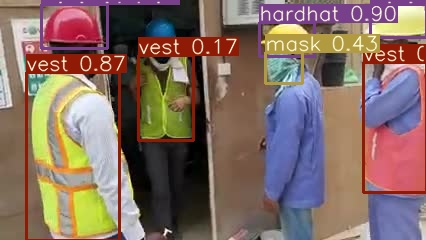

In [40]:
Image(filename='YoloV3/out_imgs/001.jpg', width=600)

#### Merge frames and convert it to video

In [41]:
!ffmpeg -r 10 -i YoloV3/out_imgs/%03d.jpg annotated_video.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib